Device: cuda
Epoch 001 | Tr 26.84% | Test 14.27% | time 33.2s
Epoch 002 | Tr 33.84% | Test 27.44% | time 33.4s
Epoch 003 | Tr 39.00% | Test 36.98% | time 34.1s
Epoch 004 | Tr 42.63% | Test 43.09% | time 33.3s
Epoch 005 | Tr 45.95% | Test 47.79% | time 32.6s
Epoch 006 | Tr 48.27% | Test 51.53% | time 34.1s
Epoch 007 | Tr 49.11% | Test 54.47% | time 33.6s
Epoch 008 | Tr 50.47% | Test 56.61% | time 32.8s
Epoch 009 | Tr 51.65% | Test 57.98% | time 34.0s
Epoch 010 | Tr 52.72% | Test 59.20% | time 35.1s
Epoch 011 | Tr 52.75% | Test 60.46% | time 33.0s
Epoch 012 | Tr 52.94% | Test 61.41% | time 33.1s
Epoch 013 | Tr 54.23% | Test 62.47% | time 32.7s
Epoch 014 | Tr 54.64% | Test 63.07% | time 32.9s
Epoch 015 | Tr 55.46% | Test 63.96% | time 33.0s
Epoch 016 | Tr 56.09% | Test 64.42% | time 33.5s
Epoch 017 | Tr 56.92% | Test 65.00% | time 33.7s
Epoch 018 | Tr 57.62% | Test 65.82% | time 33.2s
Epoch 019 | Tr 57.34% | Test 66.51% | time 33.1s
Epoch 020 | Tr 57.95% | Test 67.06% | time 33.5s
Epoch 0

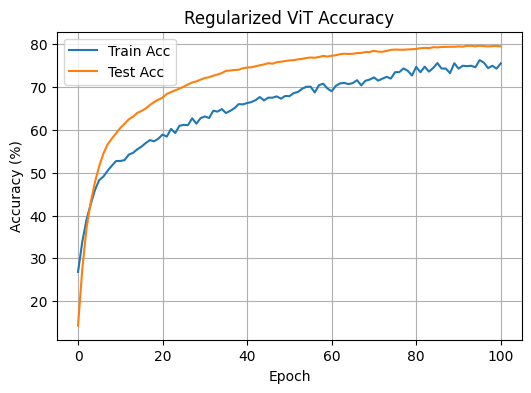

In [2]:
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
import torchvision, torchvision.transforms as T
import numpy as np, math, time, matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# -------------------------
# 1️⃣ Dataset (CIFAR-10)
# -------------------------
transform_train = T.Compose([
    T.RandomResizedCrop(32, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,)),
    T.RandomErasing(p=0.25)
])
transform_test = T.Compose([
    T.Resize(32),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=128, shuffle=False, num_workers=2)

# -------------------------
# 2️⃣ Vision Transformer (Tiny)
# -------------------------
class ViT(nn.Module):
    def __init__(self, patch_size=4, embed_dim=128, depth=6, heads=4, mlp_ratio=2.0, dropout=0.1):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, embed_dim, patch_size, patch_size)
        num_patches = (32 // patch_size) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, heads, int(embed_dim*mlp_ratio),
                                                   dropout, batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, depth)
        self.head = nn.Linear(embed_dim, 10)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embed(x).flatten(2).transpose(1,2)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) + self.pos_embed
        x = self.dropout(x)
        x = self.encoder(x)
        return self.head(x[:,0])

# -------------------------
# 3️⃣ Mixup + EMA Helpers
# -------------------------
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0: return x, y, y, 1
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def update_ema(ema_model, model, decay):
    with torch.no_grad():
        for ema_param, param in zip(ema_model.parameters(), model.parameters()):
            ema_param.data.mul_(decay).add_(param.data, alpha=1 - decay)

# -------------------------
# 4️⃣ Training Setup
# -------------------------
model = ViT().to(device)
ema_model = ViT().to(device)
ema_model.load_state_dict(model.state_dict())

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
opt = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
base_lr = 3e-4
epochs = 120
ema_decay = 0.999
patience = 5
best_test_acc = 0
no_improve = 0

train_accs, test_accs = [], []

# Warmup + Cosine LR
def warmup_cosine_lr(optimizer, base_lr, epoch, warmup_epochs, total_epochs):
    if epoch < warmup_epochs:
        lr = base_lr * (epoch + 1) / warmup_epochs
    else:
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        lr = 0.5 * base_lr * (1 + math.cos(math.pi * progress))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# -------------------------
# 5️⃣ Train + Evaluate
# -------------------------
def train_one_epoch():
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        x, y_a, y_b, lam = mixup_data(x, y, alpha=0.2)
        opt.zero_grad()
        out = model(x)
        loss = lam * criterion(out, y_a) + (1 - lam) * criterion(out, y_b)
        loss.backward()
        opt.step()
        update_ema(ema_model, model, ema_decay)
        loss_sum += loss.item() * x.size(0)
        _, pred = out.max(1)
        correct += (lam * pred.eq(y_a).sum() + (1 - lam) * pred.eq(y_b).sum()).item()
        total += y.size(0)
    return loss_sum / total, 100. * correct / total

@torch.no_grad()
def evaluate(loader, model_eval):
    model_eval.eval()
    total, correct, loss_sum = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model_eval(x)
        loss = criterion(out, y)
        loss_sum += loss.item() * x.size(0)
        _, pred = out.max(1)
        correct += pred.eq(y).sum().item()
        total += y.size(0)
    return loss_sum / total, 100. * correct / total

# -------------------------
# 6️⃣ Training Loop (Early Stop + Logging)
# -------------------------
for epoch in range(1, epochs + 1):
    warmup_cosine_lr(opt, base_lr, epoch, warmup_epochs=5, total_epochs=epochs)
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch()
    val_loss, val_acc = evaluate(testloader, ema_model)
    train_accs.append(tr_acc)
    test_accs.append(val_acc)
    print(f"Epoch {epoch:03d} | Tr {tr_acc:.2f}% | Test {val_acc:.2f}% | time {time.time()-t0:.1f}s")

    if val_acc > best_test_acc + 1e-3:
        best_test_acc = val_acc
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"⏹️ Early stopping at epoch {epoch} (patience={patience})")
            break

print(f"✅ Best Test Accuracy: {best_test_acc:.2f}%")

# -------------------------
# 7️⃣ Plot Accuracy Curve
# -------------------------
plt.figure(figsize=(6,4))
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Regularized ViT Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
